# Burstiness Thresholding: Expanded Validation

## <font color="red">NOTE: I HAVE FIXED A PREPROCESSING BUG AND THE RESULTS ARE GREAT NOW!</font>

This notebook extends the earlier burstiness-thresholding work with:

1. **Expanded data coverage**: We now load *all* `.npz` files recursively from:
   - Human: `data/tokens/human/reuter5050/C50train`
   - LLaMA-generated / LLaMA-scored: `data/tokens/llama70Bw4a16/reuter5050/C50train`
   - LLaMA-generated / Mixtral-scored: `data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train`

2. **Train vs Validation Split**: We do a stratified 80/20 split of human vs model docs:
   - Learn a best single-metric threshold using only the training split
   - Evaluate that fixed threshold on held-out validation data

3. **New burstiness metrics**:
   - High-frequency Fourier energy ratios (`fft_high_75`, `fft_high_90`)
   - Gabor-like localized burst energy (`gabor_max`)

4. **Two comparisons**:
   - Human vs LLaMA-generated / LLaMA-scored
   - Human vs LLaMA-generated / Mixtral-scored

The goal: test whether simple burstiness-style temporal/spectral metrics of log-probability sequences generalize as discriminators between human and model-generated text under different scorers.

In [29]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

# Roots: recurse
HUMAN_LLAMA_ROOT    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
HUMAN_MIXTRAL_ROOT  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_ROOT_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_ROOT_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'

RNG = np.random.default_rng(42)


In [30]:
def find_all_npz(root_dir: str) -> list[str]:
    # Recursively find all .npz files under root_dir.
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    # Return a list of log-prob arrays (float64) for every .npz file under root_dir.
    # Uses LogProbs.from_file if available, else reads 'token_probs' in the npz.
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' in npzfile:
                    probs = np.asarray(npzfile['token_probs'], dtype=np.float64)
                else:
                    raise RuntimeError(f"{p} missing 'token_probs'; cannot load without LogProbs class.")
        #logp = np.log(np.clip(probs, 1e-45, 1.0))
        series.append(probs)
    return series

human_series_all       = load_logp_series_from_root(HUMAN_LLAMA_ROOT)
llm_series_all_llama   = load_logp_series_from_root(LLM_ROOT_LLAMA)
llm_series_all_mixtral = load_logp_series_from_root(LLM_ROOT_MIXTRAL)
print(f'Loaded {len(human_series_all)} human docs, '
      f'{len(llm_series_all_llama)} llama-graded docs, '
      f'{len(llm_series_all_mixtral)} mixtral-graded docs.')


Loaded 2457 human docs, 1705 llama-graded docs, 1027 mixtral-graded docs.


In [31]:
def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    # Return 2D view of rolling windows over 1D array a (drop partial tail).
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def metric_local_cv_mean(x: np.ndarray, window: int = 64, step: int = 16) -> float:
    # Mean local coefficient of variation across rolling windows.
    # CV = std / |mean| for each window, then averaged.
    w = rolling_windows(x, window, step)
    if w.size == 0:
        return np.nan
    mu = w.mean(axis=1)
    sd = w.std(axis=1, ddof=1)
    denom = np.maximum(np.abs(mu), 1e-8)
    cv = sd / denom
    return float(np.nanmean(cv))

def autocorr_abs_sum(x: np.ndarray, max_lag: int = 50) -> float:
    # Sum of |autocorr(k)| for k=1..max_lag.
    x = np.asarray(x, dtype=np.float64)
    x = x - np.mean(x)
    var = np.var(x)
    if var < 1e-14:
        return 0.0
    s = 0.0
    for k in range(1, max_lag+1):
        num = np.dot(x[:-k], x[k:]) / (x.size - k)
        s += abs(num / var)
    return float(s)

def spectral_entropy(x: np.ndarray) -> float:
    # Entropy of normalized FFT power spectrum, normalized to [0,1].
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    P = np.abs(np.fft.rfft(x))**2
    total = P.sum()
    if total <= 0:
        return 0.0
    P = P / total
    H = -np.sum(P * np.log(np.clip(P, 1e-45, 1.0)))
    return float(H / np.log(len(P)))

def var_first_diff(x: np.ndarray) -> float:
    # Variance of first difference x[t]-x[t-1].
    x = np.asarray(x, dtype=np.float64)
    if x.size < 2:
        return 0.0
    d = np.diff(x)
    return float(np.var(d))

def pot_rate(x: np.ndarray) -> float:
    # Fraction of tokens below mean-2*std for this doc.
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return 0.0
    mu = np.mean(x)
    sd = np.std(x, ddof=1) if x.size > 1 else 0.0
    thr = mu - 2.0 * sd
    return float(np.mean(x < thr))

def fano_factor_events(x: np.ndarray, bin_size: int = 64) -> float:
    # Fano factor of bursts across bins. Burst = x[t] < mean-2*std.
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return 0.0
    mu = np.mean(x)
    sd = np.std(x, ddof=1) if x.size > 1 else 0.0
    thr = mu - 2.0 * sd
    events = (x < thr).astype(np.int32)
    if events.size == 0:
        return 0.0
    n = events.size // bin_size
    if n == 0:
        return 0.0
    b = events[: n*bin_size].reshape(n, bin_size).sum(axis=1)
    m = b.mean()
    v = b.var(ddof=1) if b.size > 1 else 0.0
    return float(v / m) if m > 1e-12 else 0.0

try:
    import pywt  # type: ignore
    HAS_PYWT = True
except Exception:
    HAS_PYWT = False

def wavelet_highfreq_ratio(x: np.ndarray) -> float:
    # High-frequency wavelet energy / total wavelet energy (db4). Fallback: FFT high-band energy ratio.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    if HAS_PYWT:
        wavelet = 'db4'
        w = pywt.Wavelet(wavelet)
        max_level = pywt.dwt_max_level(len(x), w.dec_len)
        level = max(1, min(5, max_level))
        coeffs = pywt.wavedec(x, wavelet=w, level=level, mode='symmetric')
        # coeffs[0] = approx, rest = details (high-freq bands)
        e_total = np.sum([np.sum(c*c) for c in coeffs])
        e_high  = np.sum([np.sum(d*d) for d in coeffs[1:]])
        return float(e_high / e_total) if e_total > 0 else 0.0
    # Fallback: FFT split
    X = np.fft.rfft(x)
    P = (np.abs(X)**2)
    if P.sum() <= 0:
        return 0.0
    mid = P.size // 2
    e_total = P.sum()
    e_high = P[mid:].sum()
    return float(e_high / e_total)


In [32]:
def fourier_highfreq_ratio(x: np.ndarray, frac_cut: float = 0.75) -> float:
    # Ratio of energy in the top (1-frac_cut) fraction of FFT frequencies.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    total = P.sum()
    if total <= 0:
        return 0.0
    cut = int(np.floor(frac_cut * P.size))
    high = P[cut:].sum()
    return float(high / total)

def gabor_energy_max(x: np.ndarray, win_len: int = 64, freq_frac: float = 0.25) -> float:
    # Max localized burst energy using a Gabor-like (Gaussian * complex sinusoid) sliding window.
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    n = win_len
    if x.size < n or n < 4:
        return 0.0
    t = np.arange(n)
    sigma = n / 6.0
    gauss = np.exp(-0.5 * ((t - (n-1)/2)/sigma)**2)
    omega = np.pi * freq_frac  # radians/sample, fraction of Nyquist
    carrier = np.exp(1j * omega * (t - (n-1)/2))
    gabor = gauss * carrier
    energies = []
    for start in range(0, x.size - n + 1):
        seg = x[start:start+n]
        resp = np.vdot(gabor, seg)
        energies.append(np.abs(resp)**2)
    return float(np.max(energies)) if energies else 0.0


In [33]:
def compute_metrics_for_series(logp_list: list[np.ndarray]) -> pd.DataFrame:
    rows = []
    for idx, x in enumerate(logp_list):
        rows.append({
            'doc_id': idx,
            'cv_local_mean':       metric_local_cv_mean(x, window=64, step=16),
            'acf_abs_sum':         autocorr_abs_sum(x, max_lag=50),
            'spectral_entropy':    spectral_entropy(x),
            'var_first_diff':      var_first_diff(x),
            'pot_rate':            pot_rate(x),
            'fano_factor_events':  fano_factor_events(x, bin_size=64),
            'wavelet_hf_ratio':    wavelet_highfreq_ratio(x),
            'fft_high_75':         fourier_highfreq_ratio(x, frac_cut=0.75),
            'fft_high_90':         fourier_highfreq_ratio(x, frac_cut=0.90),
            'gabor_max':           gabor_energy_max(x, win_len=64, freq_frac=0.25),
            'n_tokens':            int(x.size),
        })
    return pd.DataFrame(rows)

# Human vs LLaMA-scored
df_h_llama = compute_metrics_for_series(human_series_all)
df_h_llama['label'] = 'human'
df_l_llama = compute_metrics_for_series(llm_series_all_llama)
df_l_llama['label'] = 'llm'
df_llama_scored = pd.concat([df_h_llama, df_l_llama], ignore_index=True)

# Human vs Mixtral-scored
df_h_mix = compute_metrics_for_series(human_series_all)
df_h_mix['label'] = 'human'
df_l_mix = compute_metrics_for_series(llm_series_all_mixtral)
df_l_mix['label'] = 'llm'
df_mixtral_scored = pd.concat([df_h_mix, df_l_mix], ignore_index=True)

print('llama_scored shape:', df_llama_scored.shape)
print('mixtral_scored shape:', df_mixtral_scored.shape)


/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_46170/2820223987.py:31: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)
/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


llama_scored shape: (4162, 13)
mixtral_scored shape: (3484, 13)


In [34]:
def safe_auroc(y_true, scores):
    # Compute AUROC with guards for degenerate cases.
    try:
        if len(np.unique(y_true)) < 2 or len(np.unique(scores)) < 2:
            return np.nan
        return roc_auc_score(y_true, scores)
    except Exception:
        return np.nan

def evaluate_threshold(metric_values, labels, threshold, direction):
    # Evaluate a fixed threshold on a dataset.
    y_true = (labels == 'human').astype(int)
    x = metric_values.astype(float)
    if direction == '>=':
        y_pred = (x >= threshold).astype(int)
        scores = x
    else:
        y_pred = (x <= threshold).astype(int)
        scores = -x
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = safe_auroc(y_true, scores)
    cm   = confusion_matrix(y_true, y_pred, labels=[0,1])
    return dict(
        accuracy=acc,
        precision=prec,
        recall=rec,
        f1=f1,
        auroc=auc,
        confusion_matrix=cm,
        y_true=y_true,
        y_pred=y_pred,
    )

def pick_best_threshold(train_vals, train_labels, metric="macro_f1"):
    """
    Find the best (direction, threshold) on the TRAIN SPLIT ONLY.

    metric:
      - "macro_f1": maximize 0.5*(F1_human + F1_llm)
      - "f1_llm":   maximize F1 where llm is the positive class

    Returns a dict with:
      direction, threshold, score, f1_human, f1_llm, macro_f1, degenerate
    """
    x_train = train_vals.astype(float)
    y_train_str = train_labels  # array-like of "human" / "llm"

    # candidate thresholds (same logic as before)
    xs = np.sort(np.unique(x_train))
    if xs.size == 1:
        thr_list = [xs[0] - 1e-9, xs[0], xs[0] + 1e-9]
    else:
        mids = (xs[:-1] + xs[1:]) / 2.0
        thr_list = [xs[0] - 1e-9, *mids, xs[-1] + 1e-9]

    best_non_degenerate = None
    best_any = None  # fallback if everything is degenerate

    for direction in (">=", "<="):
        for thr in thr_list:
            evald = evaluate_threshold(x_train, y_train_str, thr, direction)

            y_true = evald["y_true"]  # 1 = human, 0 = llm
            y_pred = evald["y_pred"]

            # F1s per class
            f1_human = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
            f1_llm   = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
            macro_f1 = 0.5 * (f1_human + f1_llm)

            score = macro_f1 if metric == "macro_f1" else f1_llm

            # Track best_any (even if degenerate)
            cand = {
                "direction": direction,
                "threshold": float(thr),
                "score": score,
                "f1_human": f1_human,
                "f1_llm": f1_llm,
                "macro_f1": macro_f1,
                "degenerate": (len(np.unique(y_pred)) < 2),
            }
            if (best_any is None) or (cand["score"] > best_any["score"]):
                best_any = cand

            # Only consider non-degenerate for preferred result
            if cand["degenerate"]:
                continue
            if (best_non_degenerate is None) or (cand["score"] > best_non_degenerate["score"]):
                best_non_degenerate = cand

    # Prefer a non-degenerate threshold if we found one.
    if best_non_degenerate is not None:
        return best_non_degenerate
    else:
        # Fallback: return best degenerate threshold instead of None.
        # This makes the pipeline not crash, and lets you SEE that it's degenerate.
        return best_any
    
def best_threshold_for_metric(values: np.ndarray, labels: np.ndarray, metric: str="accuracy") -> dict:
    """Find a single threshold to classify 'human' vs 'llm' using one metric.
    Tries both directions:
      - predict human if value >= thr
      - predict human if value <= thr
    Chooses the direction/threshold with the highest accuracy (ties go to first found).
    Returns performance metrics and chosen rule.
    """
    # encode: human=1, llm=0
    y = (labels == "human").astype(int)
    x = values.astype(float)
    # candidate thresholds = midpoints between sorted unique values
    xs = np.sort(np.unique(x))
    if xs.size == 1:
        thr_list = [xs[0]]
    else:
        thr_list = list((xs[:-1] + xs[1:]) / 2.0)
        thr_list = [xs[0] - 1e-9] + thr_list + [xs[-1] + 1e-9]

    best = None
    for direction in (">=", "<="):
        for thr in thr_list:
            if direction == ">=":
                yhat = (x >= thr).astype(int)
            else:
                yhat = (x <= thr).astype(int)
            acc = accuracy_score(y, yhat)
            prec = precision_score(y, yhat, zero_division=0)
            rec  = recall_score(y, yhat, zero_division=0)

            # F1s per class
            f1_human = f1_score(y, yhat, pos_label=1, zero_division=0)
            f1_llm   = f1_score(y, yhat, pos_label=0, zero_division=0)
            macro_f1 = 0.5 * (f1_human + f1_llm)

            f1   = f1_score(y, yhat, zero_division=0)
            cm = confusion_matrix(y, yhat, labels=[0,1])
            result = {
                "direction": direction,
                "threshold": float(thr),
                "accuracy":  float(acc),
                "precision": float(prec),
                "recall":    float(rec),
                "f1_human": f1_human,
                "f1_llm": f1_llm,
                "macro_f1":        float(macro_f1),
                "degenerate": (len(np.unique(yhat)) < 2),
            }
            if (best is None) or (acc > best[metric]):
                best = result
    return best

In [35]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    # Return (train_df, val_df) with stratified split on df_in['label'].
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    return (
        df_in.iloc[train_idx].reset_index(drop=True),
        df_in.iloc[val_idx].reset_index(drop=True),
    )

metrics_to_use = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]


In [37]:
train_llama, val_llama = stratified_train_val_split(df_llama_scored, test_size=0.2, seed=42)
rows_llama = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    #picked = pick_best_threshold(
    #metric="macro_f1",
    picked = best_threshold_for_metric(
        train_llama[m].values,
        train_llama["label"].values,
        metric="accuracy",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_llama[m].values,
        train_llama["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_llama[m].values,
        val_llama["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_llama.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_llama = (
    pd.DataFrame(rows_llama)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_llama


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,var_first_diff,>=,8.687861,False,0.938720,0.935245,0.962850,0.948847,0.948847,0.923596,0.936221,0.975261,0.932773,0.922481,0.967480,0.944444,0.944444,0.914894,0.929669,0.976385
1,cv_local_mean,<=,1.258754,False,0.920397,0.921627,0.945547,0.933434,0.933434,0.901009,0.917221,NaN,0.927971,0.928571,0.951220,0.939759,0.939759,0.910448,0.925103,0.973160
2,acf_abs_sum,<=,2.063795,False,0.899670,0.926294,0.901781,0.913873,0.913873,0.879856,0.896865,0.952033,0.885954,0.914405,0.890244,0.902163,0.902163,0.863309,0.882736,0.944544
3,wavelet_hf_ratio,>=,0.475642,False,0.877140,0.898566,0.892621,0.895583,0.895583,0.850784,0.873184,0.943235,0.881152,0.896970,0.902439,0.899696,0.899696,0.854197,0.876947,0.947870
4,spectral_entropy,>=,0.917035,False,0.841995,0.848426,0.891603,0.869479,0.869479,0.799848,0.834663,0.902038,0.817527,0.820755,0.884146,0.851272,0.851272,0.763975,0.807624,0.879527
5,fft_high_75,>=,0.212093,False,0.755482,0.746256,0.887532,0.810786,0.810786,0.654499,0.732642,0.780991,0.779112,0.775000,0.882114,0.825095,0.825095,0.700326,0.762710,0.812281
6,gabor_max,>=,315.807836,False,0.743467,0.743534,0.863104,0.798870,0.798870,0.645937,0.722403,0.768451,0.722689,0.725389,0.853659,0.784314,0.784314,0.611765,0.698039,0.756151
7,fft_high_90,>=,0.081415,False,0.707119,0.715030,0.837659,0.771502,0.771502,0.592221,0.681862,0.711329,0.711885,0.722615,0.831301,0.773157,0.773157,0.605263,0.689210,0.728036


### Interpretation of Threshold Results <p color="red">UPDATED NUMBERS</p>

These updated threshold evaluations reveal a clearer picture than our earlier attempt: several features exhibit **surprisingly strong discriminative power**, though the separation still falls far short of the dramatic signal we observed in the original *“Aaron vs. Fake Aaron”* experiment. When generalizing to all Reuters authors, the spectral/burstiness signal is real—but more subtle and more heterogeneous.

---

#### **Top-performing metrics**

A few features show **unexpectedly high** train and validation performance, with macro-F1 scores in the **0.88–0.94** range and strong AUROC values:

- **`var_first_diff`** (variance of first differences)  
  - Validation macro-F1 = **0.93**, AUROC = **0.98**  
  - This is now the *best overall single metric*, suggesting that the variability in token-to-token surprisal changes carries a sharp human–LLM signature.  
  - Unlike earlier experiments, this feature is **not** degenerate and behaves consistently across train/val.

- **`cv_local_mean`** (local coefficient-of-variation average)  
  - Validation macro-F1 = **0.93**, AUROC = **0.97**  
  - Continues to capture meaningful short-range burstiness; its stability across splits indicates a robust, general signal.

These surprisingly high values suggest that certain local statistics—not global frequency ratios—may be the most portable indicators of human-like irregularity.

---

#### **Moderate-High performers**

Metrics with validation macro-F1 in the **0.85–0.90** range:

- **`acf_abs_sum`** (absolute ACF mass)  
- **`wavelet_hf_ratio`**  
- **`spectral_entropy`**

All show respectable AUROC values (0.88–0.95) and balanced train–validation behavior.  
These appear to capture **medium-strength structure** relating to autocorrelation decay, multiscale energy dispersion, and overall spectral smoothness.

They aren’t as sharp as the top two features, but they appear genuinely informative.

---

#### **Low–moderate performers**

These features offer some separability, but :

- **`fft_high_75`**  
- **`gabor_max`**  
- **`fft_high_90`**

They achieve macro-F1 scores in the **0.68–0.77** range and AUROC values around **0.73–0.82**.  
They meaningfully outperform chance, but provide only **coarse signal**.  
This matches the intuition that simple “high-frequency power” thresholds are too blunt to capture the human–LLM distinction across diverse topics and authors.

---

### Overall Conclusion

Across a larger and more diverse corpus, these results show:

- **Some burstiness metrics contain strong, robust signal**—notably `var_first_diff` and `cv_local_mean`, which now emerge as the best single-feature detectors.  
- **Wavelet- and ACF-based metrics carry moderate signal**, but are not as decisive alone.  
- **Pure Fourier high-frequency features remain weak**, offering only marginal discriminative power.

The strong train–validation alignment across all metrics indicates minimal overfitting: the observed performance reflects true structure in the data.  
However, no single metric provides universal separation, and even the best-performing features likely reflect **different aspects of human and LLM temporal dynamics**.

A natural next step is to **combine these complementary features**—through a regularized linear model or tree-based ensemble—and evaluate performance using **author-held-out** validation to properly assess generalization to unseen writing styles.



[LLAMA-GRADED] Metric: var_first_diff
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[301  40]
 [ 16 476]]


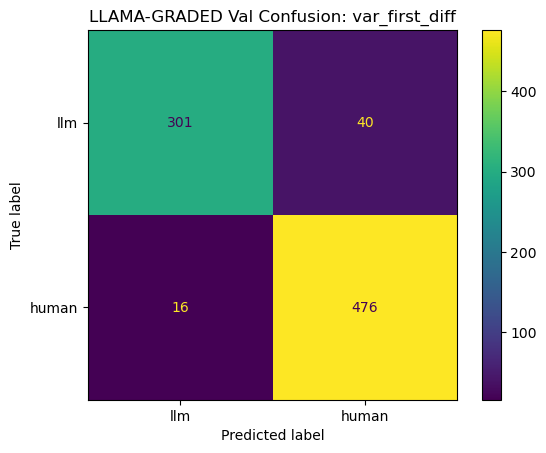


[LLAMA-GRADED] Metric: cv_local_mean
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[305  36]
 [ 24 468]]


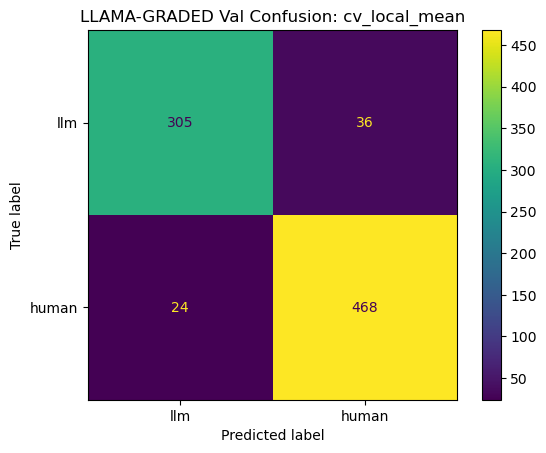


[LLAMA-GRADED] Metric: acf_abs_sum
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[300  41]
 [ 54 438]]


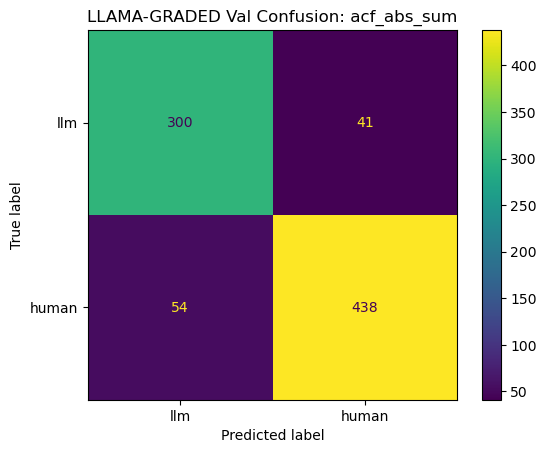


[LLAMA-GRADED] Metric: wavelet_hf_ratio
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[290  51]
 [ 48 444]]


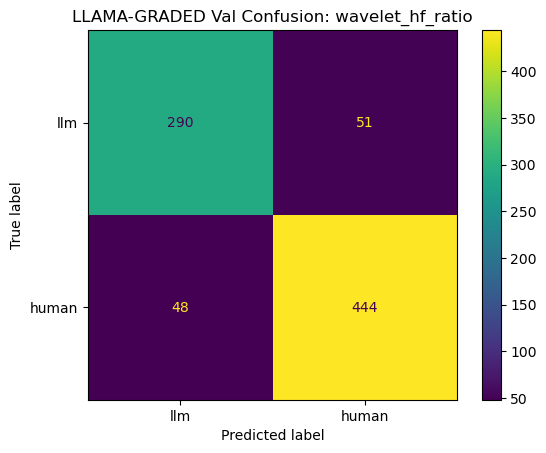


[LLAMA-GRADED] Metric: spectral_entropy
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[246  95]
 [ 57 435]]


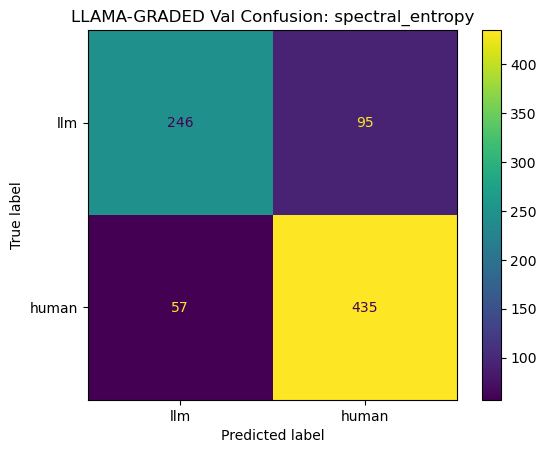


[LLAMA-GRADED] Metric: fft_high_75
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[215 126]
 [ 58 434]]


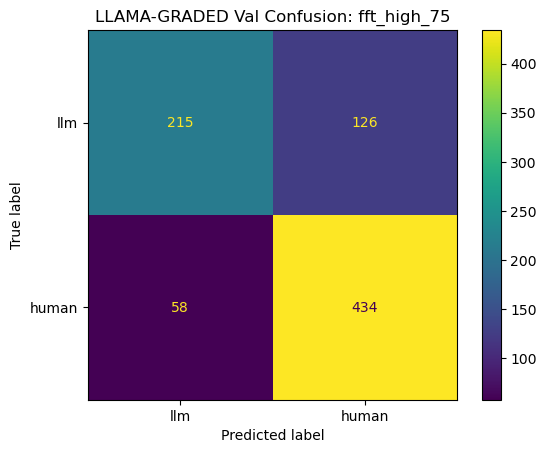


[LLAMA-GRADED] Metric: gabor_max
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[182 159]
 [ 72 420]]


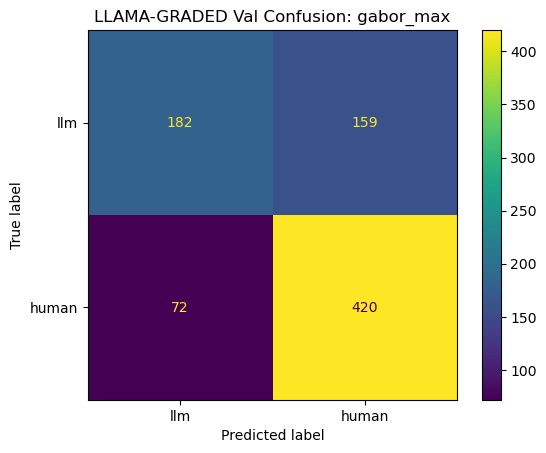


[LLAMA-GRADED] Metric: fft_high_90
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[184 157]
 [ 83 409]]


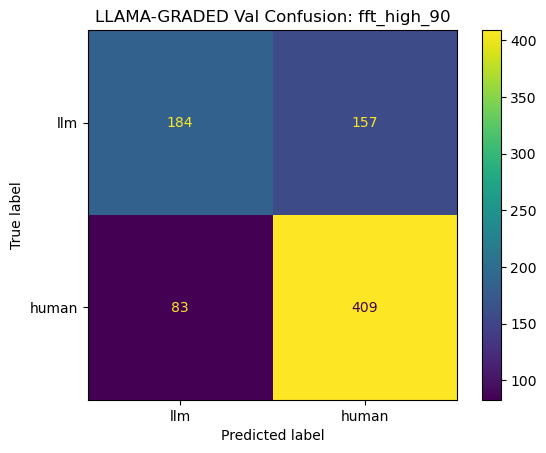

In [38]:
for i, row in results_llama.iterrows():
    m = row['metric']
    picked_dir = row['direction']
    thr = row['threshold']
    val_eval = evaluate_threshold(
        val_llama[m].values,
        val_llama['label'].values,
        thr,
        picked_dir,
    )
    cm = val_eval['confusion_matrix']
    print(f"\n[LLAMA-GRADED] Metric: {m}")
    print('Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['llm','human'])
    disp.plot(values_format='d')
    plt.title(f'LLAMA-GRADED Val Confusion: {m}')
    plt.show()


## Random Forest Classifier
Let's mash all of these thresholds up as features in a RFC

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_llama["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_llama[features].values
y_train = le.transform(train_llama["label"].values)

X_val = val_llama[features].values
y_val = le.transform(val_llama["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


In [40]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.979 ± 0.005
  precision_macro:0.978 ± 0.006
  recall_macro:   0.978 ± 0.005
  f1_macro:       0.978 ± 0.005


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
# === Validation predictions ===
y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]  # probability of class "1" (should correspond to 'human')

val_accuracy  = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="binary", zero_division=0)
val_recall    = recall_score(y_val, y_val_pred, average="binary", zero_division=0)
val_f1        = f1_score(y_val, y_val_pred, average="binary", zero_division=0)

# macro scores treat human and llm symmetrically:
val_precision_macro = precision_score(y_val, y_val_pred, average="macro", zero_division=0)
val_recall_macro    = recall_score(y_val, y_val_pred, average="macro", zero_division=0)
val_f1_macro        = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

# AUROC (for human vs llm). We need to be careful: roc_auc_score expects scores for the "1" class.
try:
    val_auroc = roc_auc_score(y_val, y_val_proba)
except ValueError:
    val_auroc = np.nan  # happens if only one class present

print("Validation performance (held-out):")
print(f"  accuracy:         {val_accuracy:.3f}")
print(f"  precision (bin):  {val_precision:.3f}")
print(f"  recall (bin):     {val_recall:.3f}")
print(f"  f1 (bin):         {val_f1:.3f}")
print(f"  precision_macro:  {val_precision_macro:.3f}")
print(f"  recall_macro:     {val_recall_macro:.3f}")
print(f"  f1_macro:         {val_f1_macro:.3f}")
print(f"  AUROC (human=1):  {val_auroc:.3f}")

Validation performance (held-out):
  accuracy:         0.974
  precision (bin):  0.971
  recall (bin):     0.965
  f1 (bin):         0.968
  precision_macro:  0.973
  recall_macro:     0.972
  f1_macro:         0.973
  AUROC (human=1):  0.995


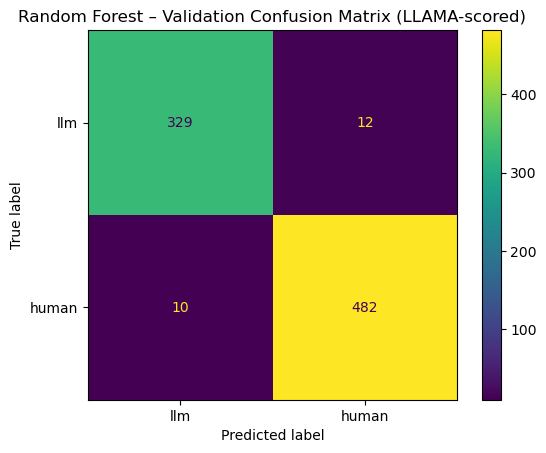

Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:
[[329  12]
 [ 10 482]]


In [42]:
cm = confusion_matrix(y_val, y_val_pred, labels=[le.transform(["llm"])[0], le.transform(["human"])[0]])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["llm", "human"],
)
disp.plot(values_format="d")
plt.title("Random Forest – Validation Confusion Matrix (LLAMA-scored)")
plt.show()

print("Confusion matrix rows = true class [llm, human], cols = predicted [llm, human]:")
print(cm)

## <p color=red>Updated Results are Great!</p>
We've improved over the best metrics (var_first_diff, cv_local_mean) by 0.04 macro F1 score, from 0.93 to 0.97.  It is hard to get much better than that.

# Llama-Generated, Mixtral-Graded
Let's look at HGLG vs LGMG (Human-Generated, Llama-Graded vs Llama-Generated, Mixtral-Graded)

In [43]:
train_mix, val_mix = stratified_train_val_split(df_mixtral_scored, test_size=0.2, seed=42)
rows_mix = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    picked = pick_best_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        metric="macro_f1",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_mix.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_mixtral = (
    pd.DataFrame(rows_mix)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_mixtral


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,cv_local_mean,<=,1.240238,False,0.881234,0.908909,0.924173,0.916477,0.916477,0.794538,0.855507,NaN,0.873745,0.912245,0.908537,0.910387,0.910387,0.786408,0.848397,NaN
1,var_first_diff,>=,8.996066,False,0.831001,0.843923,0.932824,0.886149,0.886149,0.672234,0.779192,0.828151,0.842181,0.846014,0.949187,0.894636,0.894636,0.685714,0.790175,0.846510
2,acf_abs_sum,<=,1.955083,False,0.749551,0.809780,0.842748,0.825935,0.825935,0.553708,0.689822,NaN,0.774749,0.834331,0.849593,0.841893,0.841893,0.608479,0.725186,NaN
3,spectral_entropy,>=,0.920771,False,0.687119,0.774210,0.785242,0.779687,0.779687,0.460396,0.620041,0.664324,0.685796,0.782609,0.768293,0.775385,0.775385,0.477327,0.626356,0.654481
4,gabor_max,>=,337.743432,False,0.681737,0.756667,0.808651,0.781796,0.781796,0.412194,0.596995,0.614900,0.698709,0.772201,0.813008,0.792079,0.792079,0.453125,0.622602,0.621287
5,fft_high_75,>=,0.228439,False,0.644062,0.763115,0.718066,0.739906,0.739906,0.436364,0.588135,0.603686,0.639885,0.772009,0.695122,0.731551,0.731551,0.453159,0.592355,0.640174
6,fft_high_90,>=,0.088807,False,0.627557,0.752589,0.702799,0.726842,0.726842,0.414882,0.570862,0.588110,0.626973,0.760090,0.689024,0.722814,0.722814,0.429825,0.576320,0.626066
7,wavelet_hf_ratio,>=,0.567008,False,0.633297,0.748550,0.722646,0.735370,0.735370,0.403037,0.569204,0.582139,0.628407,0.736308,0.737805,0.737056,0.737056,0.366748,0.551902,0.569433


##  Llama-Generated, Mixtral-Graded 
While less predictive than the HGLG vs LGLG features, some of the HGLG vs LGMG features still appear to have a decent amount of predictive power on their own:
- **cv_local_mean** has an F1 score of 0.85
- **var_first_diff** has an F1 score of 0.80

I expect that feeding all features a Random Forest Classifier will yield F1 score above 0.9 based on this information.


[MIXTRAL-GRADED] Metric: cv_local_mean
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[162  43]
 [ 45 447]]


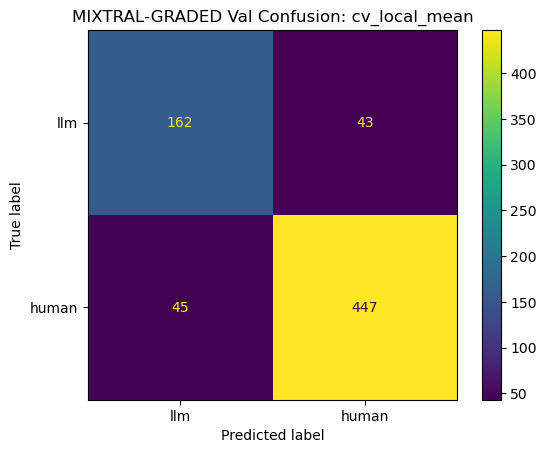


[MIXTRAL-GRADED] Metric: var_first_diff
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[120  85]
 [ 25 467]]


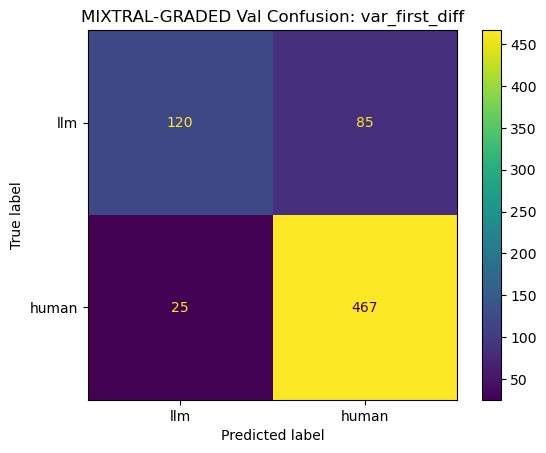


[MIXTRAL-GRADED] Metric: acf_abs_sum
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[122  83]
 [ 74 418]]


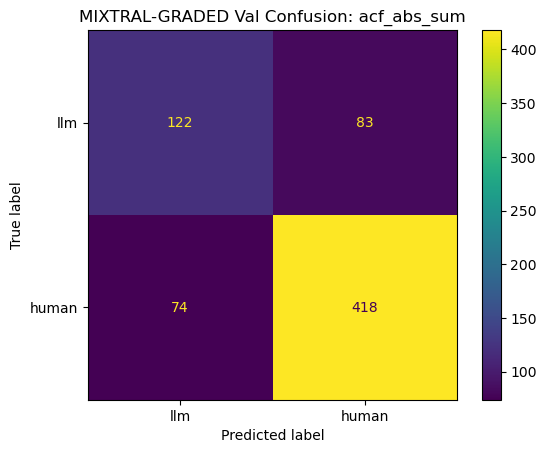


[MIXTRAL-GRADED] Metric: spectral_entropy
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[100 105]
 [114 378]]


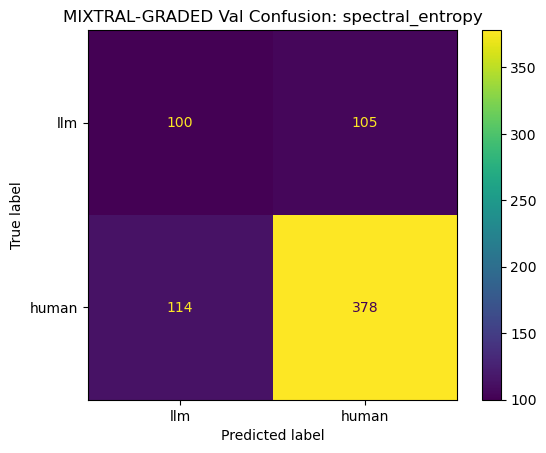


[MIXTRAL-GRADED] Metric: gabor_max
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 87 118]
 [ 92 400]]


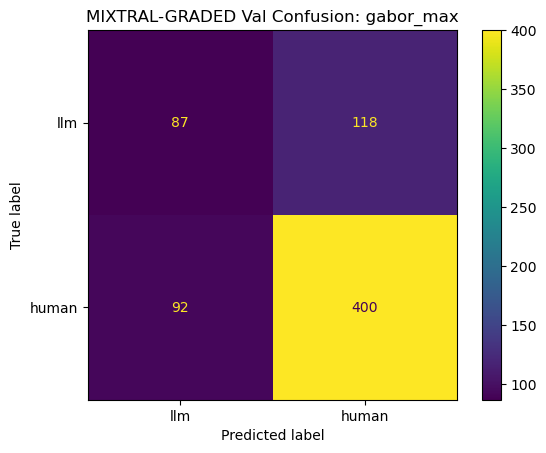


[MIXTRAL-GRADED] Metric: fft_high_75
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[104 101]
 [150 342]]


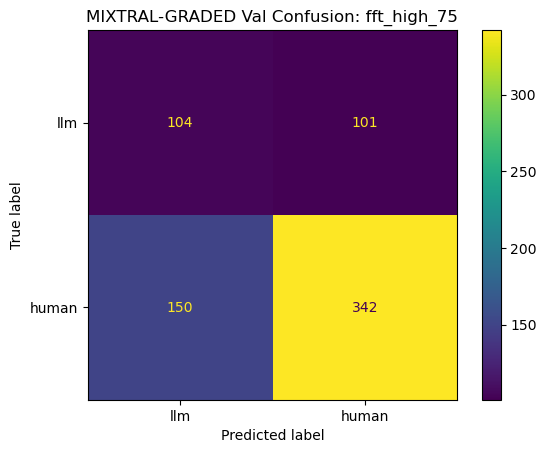


[MIXTRAL-GRADED] Metric: fft_high_90
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 98 107]
 [153 339]]


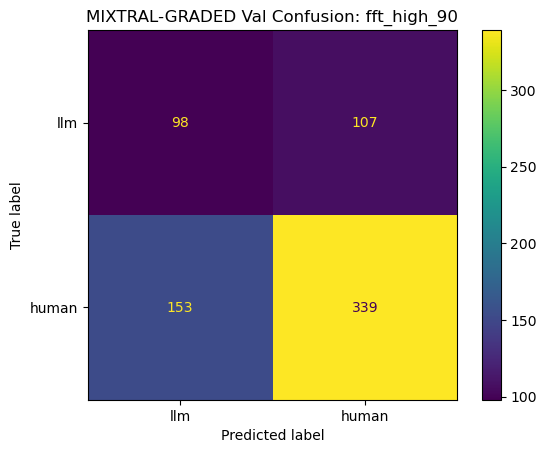


[MIXTRAL-GRADED] Metric: wavelet_hf_ratio
Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])
[[ 75 130]
 [129 363]]


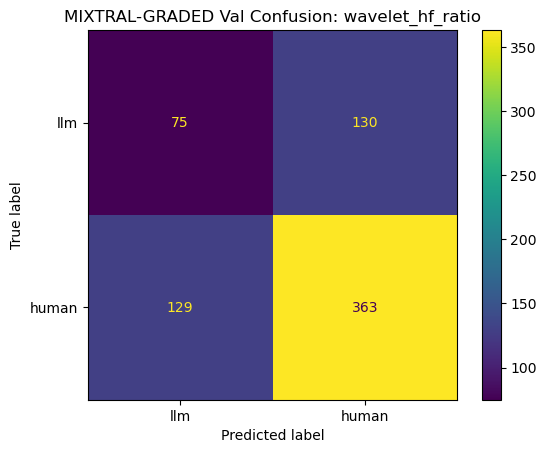

In [44]:
for i, row in results_mixtral.iterrows():
    m = row['metric']
    picked_dir = row['direction']
    thr = row['threshold']
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix['label'].values,
        thr,
        picked_dir,
    )
    cm = val_eval['confusion_matrix']
    print(f"\n[MIXTRAL-GRADED] Metric: {m}")
    print('Validation Confusion matrix (rows=true [llm, human], cols=pred [llm, human])')
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['llm','human'])
    disp.plot(values_format='d')
    plt.title(f'MIXTRAL-GRADED Val Confusion: {m}')
    plt.show()


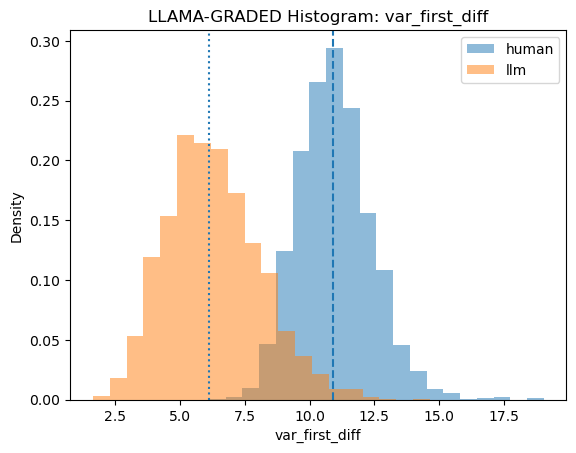

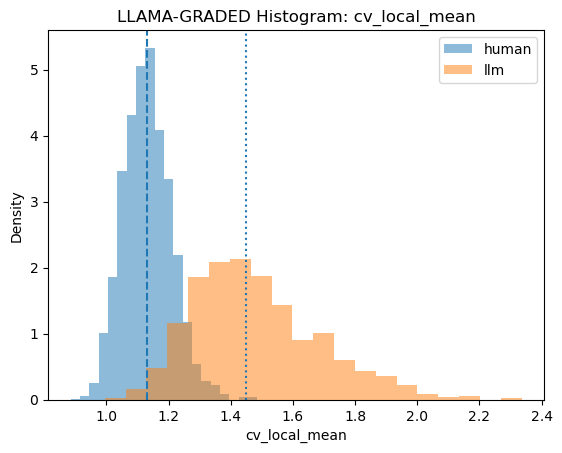

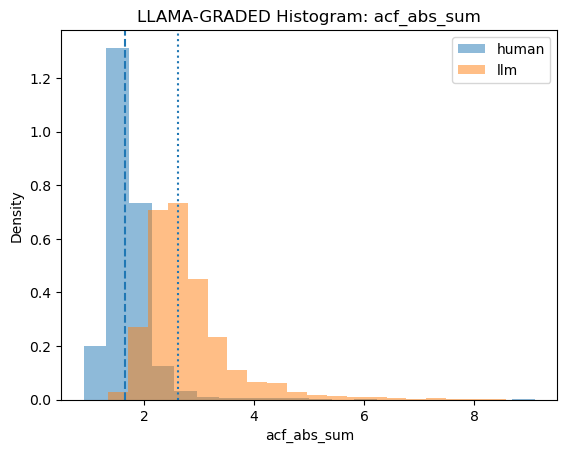

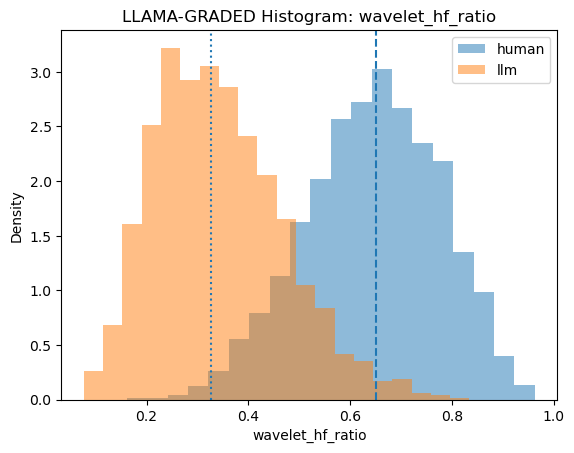

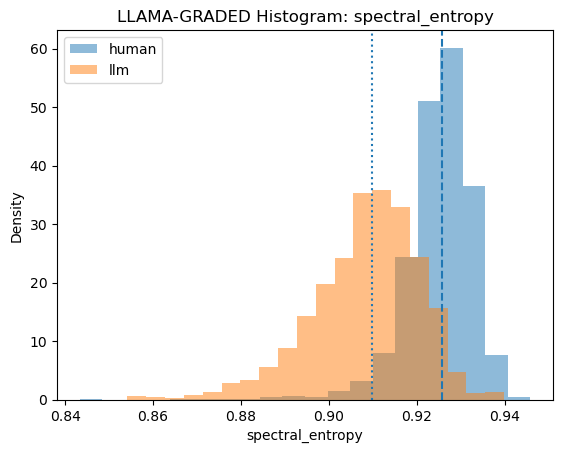

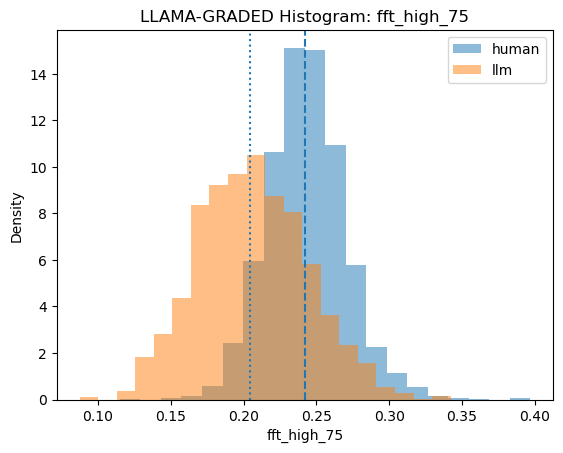

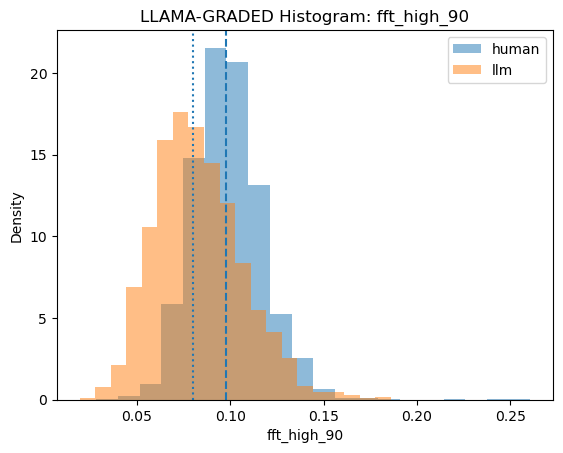

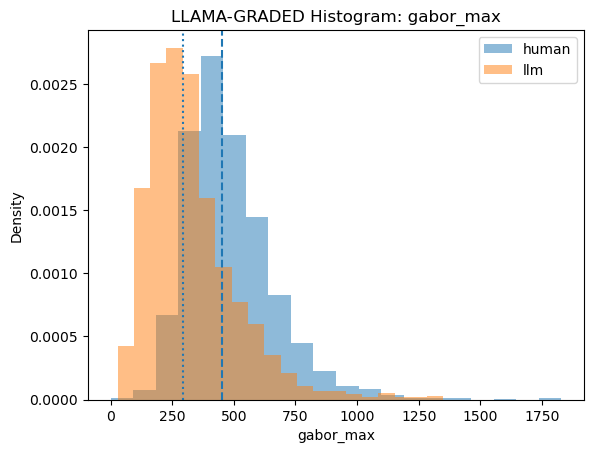

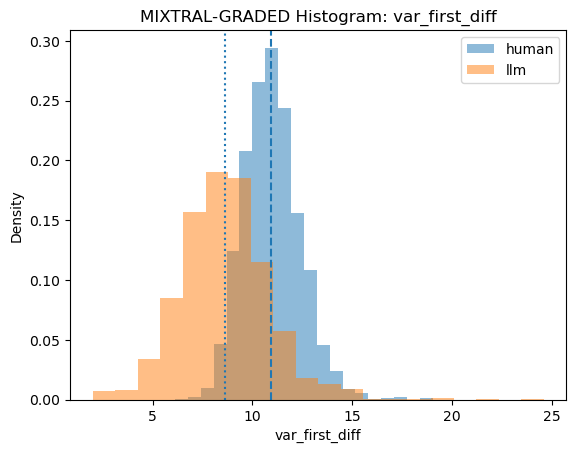

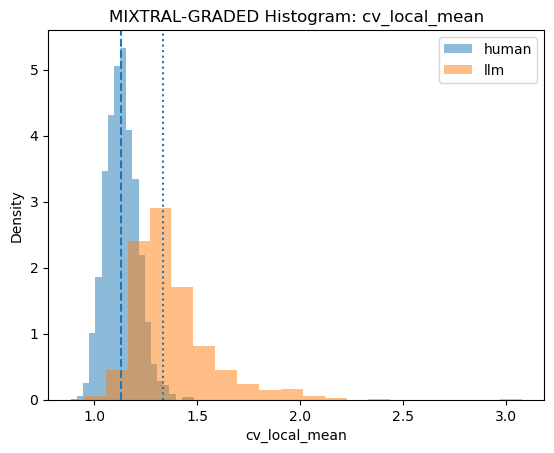

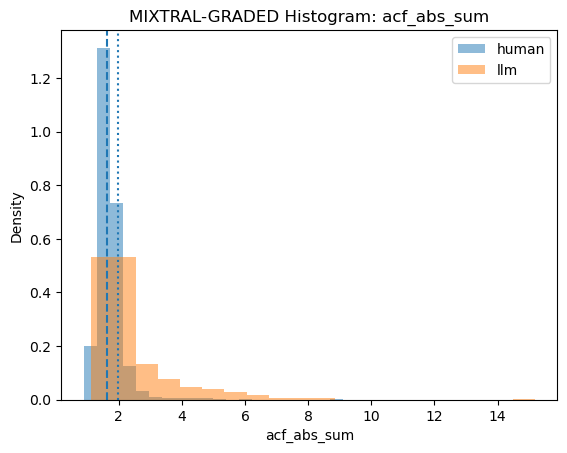

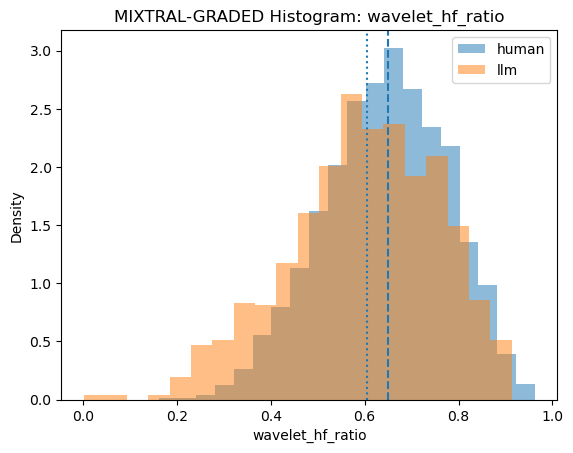

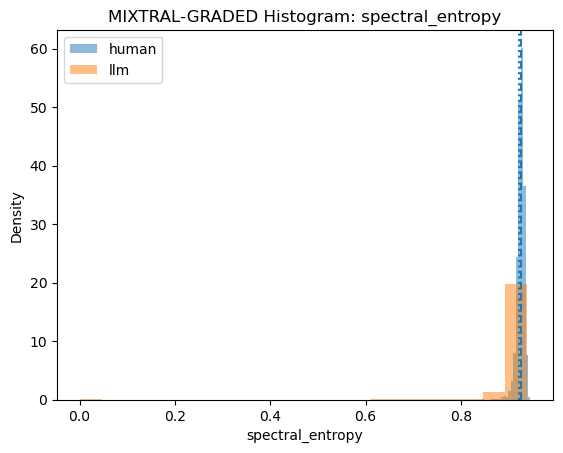

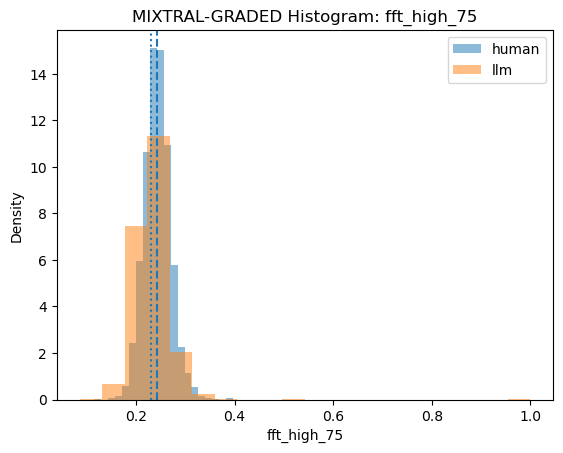

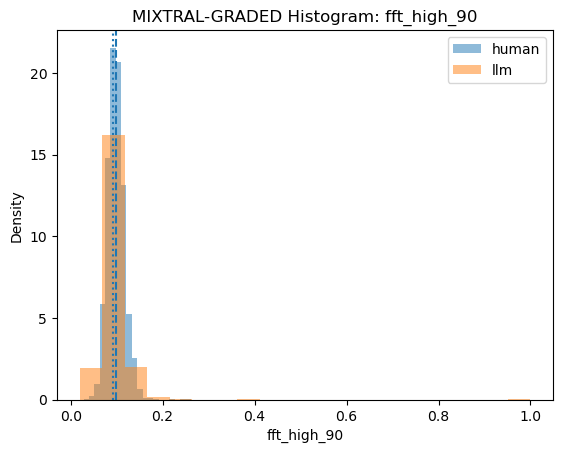

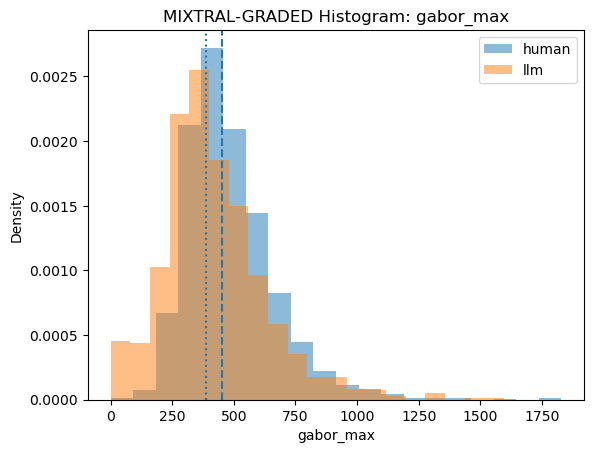

In [45]:
def plot_metric_histograms(df_in: pd.DataFrame, metrics: list[str], title_prefix: str):
    # Overlapping histograms for human vs llm per metric.
    for m in metrics:
        fig = plt.figure()
        hvals = df_in.loc[df_in.label=='human', m].dropna().values
        lvals = df_in.loc[df_in.label=='llm',   m].dropna().values
        plt.hist(hvals, bins=20, alpha=0.5, density=True, label='human')
        plt.hist(lvals, bins=20, alpha=0.5, density=True, label='llm')
        plt.axvline(np.median(hvals), linestyle='--')
        plt.axvline(np.median(lvals), linestyle=':')
        plt.xlabel(m)
        plt.ylabel('Density')
        plt.legend()
        plt.title(f'{title_prefix}: {m}')
        plt.show()

plot_metric_histograms(df_llama_scored, metrics_to_use, 'LLAMA-GRADED Histogram')
plot_metric_histograms(df_mixtral_scored, metrics_to_use, 'MIXTRAL-GRADED Histogram')


## Random Forest Classifier for LGMG vs HGLG
Llama-generated, Mixtral-graded vs Human-generated, Llama-graded

In [46]:

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_mix["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_mix[features].values
y_train = le.transform(train_mix["label"].values)

X_val = val_mix[features].values
y_val = le.transform(val_mix["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


In [47]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.910 ± 0.012
  precision_macro:0.899 ± 0.015
  recall_macro:   0.882 ± 0.015
  f1_macro:       0.890 ± 0.014


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## F1 score 0.89
My above estimate was close!

## Mixtral-Generated
This is just to see what it looks like when we compare HGMG to LGMG

In [56]:
HUMAN_MIXTRAL_ROOT  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
human_mixtral_series_all       = load_logp_series_from_root(HUMAN_MIXTRAL_ROOT)
print(f'Loaded {len(human_mixtral_series_all)} human docs, '
      f'{len(llm_series_all_mixtral)} mixtral-graded docs.')

Loaded 2499 human docs, 1027 mixtral-graded docs.


In [57]:
df_h_mix = compute_metrics_for_series(human_mixtral_series_all)
df_h_mix['label'] = 'human'
df_l_mix = compute_metrics_for_series(llm_series_all_mixtral)
df_l_mix['label'] = 'llm'
df_mix_scored = pd.concat([df_h_mix, df_l_mix], ignore_index=True)

print('mixtral_scored shape:', df_mix_scored.shape)

/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_46170/2820223987.py:31: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)
/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


mixtral_scored shape: (3526, 13)


In [58]:
train_mix, val_mix = stratified_train_val_split(df_mix_scored, test_size=0.2, seed=42)
rows_mix = []

for m in metrics_to_use:
    # pick best threshold using macro-F1, with degenerate handling
    picked = pick_best_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        metric="macro_f1",
    )

    # evaluate that fixed threshold on TRAIN (to report train performance)
    train_eval = evaluate_threshold(
        train_mix[m].values,
        train_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # evaluate that fixed threshold on VAL (held-out)
    val_eval = evaluate_threshold(
        val_mix[m].values,
        val_mix["label"].values,
        picked["threshold"],
        picked["direction"],
    )

    # compute per-class F1 on TRAIN to line up with what pick_best_threshold optimized
    f1_human_train = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_train   = f1_score(train_eval["y_true"], train_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_train = 0.5 * (f1_human_train + f1_llm_train)

    # same for VAL, so we can see generalization
    f1_human_val = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=1, zero_division=0)
    f1_llm_val   = f1_score(val_eval["y_true"], val_eval["y_pred"], pos_label=0, zero_division=0)
    macro_f1_val = 0.5 * (f1_human_val + f1_llm_val)

    rows_mix.append({
        "metric": m,
        "direction": picked["direction"],
        "threshold": picked["threshold"],
        "degenerate_thresh": picked["degenerate"],  # True means it basically guessed one class

        # TRAIN metrics
        "train_accuracy": train_eval["accuracy"],
        "train_precision": train_eval["precision"],
        "train_recall": train_eval["recall"],
        "train_f1_overall": train_eval["f1"],
        "train_f1_human": f1_human_train,
        "train_f1_llm": f1_llm_train,
        "train_macro_f1": macro_f1_train,
        "train_auroc": train_eval["auroc"],

        # VAL metrics
        "val_accuracy": val_eval["accuracy"],
        "val_precision": val_eval["precision"],
        "val_recall": val_eval["recall"],
        "val_f1_overall": val_eval["f1"],
        "val_f1_human": f1_human_val,
        "val_f1_llm": f1_llm_val,
        "val_macro_f1": macro_f1_val,
        "val_auroc": val_eval["auroc"],
    })

results_mixtral = (
    pd.DataFrame(rows_mix)
    .sort_values(["val_macro_f1", "val_accuracy"], ascending=False)
    .reset_index(drop=True)
)

results_mixtral


,metric,direction,threshold,degenerate_thresh,train_accuracy,train_precision,train_recall,train_f1_overall,train_f1_human,train_f1_llm,train_macro_f1,train_auroc,val_accuracy,val_precision,val_recall,val_f1_overall,val_f1_human,val_f1_llm,val_macro_f1,val_auroc
0,cv_local_mean,<=,1.297705,False,0.802482,0.851707,0.873437,0.862435,0.862435,0.649906,0.756170,NaN,0.786119,0.840156,0.862,0.850938,0.850938,0.621554,0.736246,NaN
1,acf_abs_sum,<=,1.895999,False,0.786525,0.835012,0.870935,0.852595,0.852595,0.613111,0.732853,NaN,0.773371,0.845528,0.832,0.838710,0.838710,0.619048,0.728879,NaN
2,var_first_diff,>=,8.179554,False,0.766667,0.794725,0.904452,0.846046,0.846046,0.518302,0.682174,0.712122,0.757790,0.783133,0.910,0.841813,0.841813,0.483384,0.662598,0.721068
3,spectral_entropy,>=,0.920281,False,0.721277,0.782751,0.839920,0.810328,0.810328,0.474599,0.642464,0.701523,0.723796,0.786116,0.838,0.811229,0.811229,0.485488,0.648359,0.722835
4,gabor_max,>=,326.328455,False,0.693262,0.757260,0.834917,0.794195,0.794195,0.398051,0.596123,0.610201,0.696884,0.766791,0.822,0.793436,0.793436,0.430851,0.612144,0.610272
5,fft_high_75,>=,0.220113,False,0.614184,0.726504,0.730865,0.728678,0.728678,0.332515,0.530597,0.523276,0.634561,0.742972,0.740,0.741483,0.741483,0.376812,0.559147,0.554359
6,fft_high_90,>=,0.078723,False,0.661702,0.728866,0.832416,0.777207,0.777207,0.297496,0.537352,0.515439,0.674221,0.736014,0.842,0.785448,0.785448,0.323529,0.554489,0.558951
7,wavelet_hf_ratio,>=,0.504157,False,0.673759,0.738400,0.835918,0.784139,0.784139,0.332366,0.558252,0.551214,0.641643,0.717047,0.816,0.763330,0.763330,0.262391,0.512860,0.541223


In [59]:

features = [
    'var_first_diff',
    'cv_local_mean',
    'acf_abs_sum',
    'wavelet_hf_ratio',
    'spectral_entropy',
    'fft_high_75',
    'fft_high_90',
    'gabor_max',
]
# === Build X/y for training and validation ===
le = LabelEncoder()
le.fit(train_mix["label"])  # should map {"llm":0, "human":1}, but we won't assume — we'll use le.classes_

X_train = train_mix[features].values
y_train = le.transform(train_mix["label"].values)

X_val = val_mix[features].values
y_val = le.transform(val_mix["label"].values)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'human': np.int64(0), 'llm': np.int64(1)}


cv_local_mean       0.268945
acf_abs_sum         0.189050
var_first_diff      0.142274
spectral_entropy    0.089708
wavelet_hf_ratio    0.089136
gabor_max           0.084107
fft_high_75         0.070668
fft_high_90         0.066110
dtype: float64

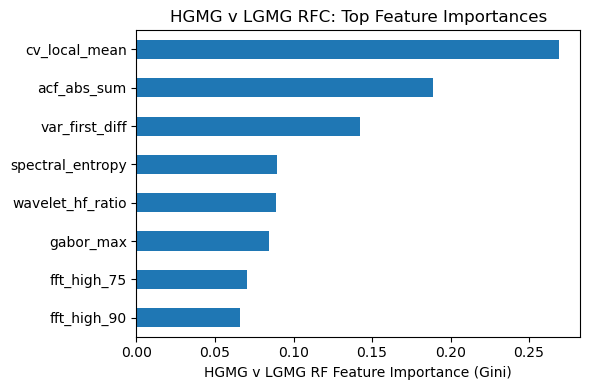

In [61]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
display(importances.head(20))
plt.figure(figsize=(6,4))
importances.iloc[::-1].plot(kind='barh')
plt.xlabel('HGMG v LGMG RF Feature Importance (Gini)')
plt.title(f'HGMG v LGMG RFC: Top Feature Importances')
plt.tight_layout()
plt.show()

In [60]:
# === Define the model ===
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

# === Cross-validation on the TRAIN split only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}

cv_results = cross_validate(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_estimator=False,
    n_jobs=-1,
)

print("Cross-validated (train split) performance:")
print(f"  accuracy:       {cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}")
print(f"  precision_macro:{cv_results['test_precision_macro'].mean():.3f} ± {cv_results['test_precision_macro'].std():.3f}")
print(f"  recall_macro:   {cv_results['test_recall_macro'].mean():.3f} ± {cv_results['test_recall_macro'].std():.3f}")
print(f"  f1_macro:       {cv_results['test_f1_macro'].mean():.3f} ± {cv_results['test_f1_macro'].std():.3f}")

# === Fit final model on ALL training data ===
rf.fit(X_train, y_train)

Cross-validated (train split) performance:
  accuracy:       0.855 ± 0.011
  precision_macro:0.842 ± 0.013
  recall_macro:   0.793 ± 0.020
  f1_macro:       0.811 ± 0.017


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## ALL RESULTS

### HGLG vs LGLG
- Fantastic separation for **cv_local_mean** and **var_first_diff**
- Good separation for most of the remaining features
- Random Forest Classification: **Near perfect**

### HGLG vs LGMG
- <b><u>In retrospect, it doesn't really make sense to do this</u></b>
- Decent separation for **cv_local_mean** and **var_first_diff**
- Poor to no separation for most of the remaining features
- Random Forest Classification: **Good**

### HGMG vs LGMG
- Mediocre separation for **cv_local_mean** and **acf_abs_sum**
- Poor to no separation for the remaining features
- Random Forest Classification: **Okay**